In [1]:
import pandas as pd
import numpy as np
import re
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


from transformers import (
    AdamW,
    get_cosine_schedule_with_warmup,
    RobertaTokenizer,
    RobertaModel,
    RobertaConfig
)

In [2]:
!mkdir data
config = RobertaConfig.from_pretrained("roberta-large")
config.to_json_file("./data/config.json")

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [3]:
df_train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
df_test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
sub = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
df_train

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [4]:
df_train.isna().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

<AxesSubplot:xlabel='target', ylabel='Count'>

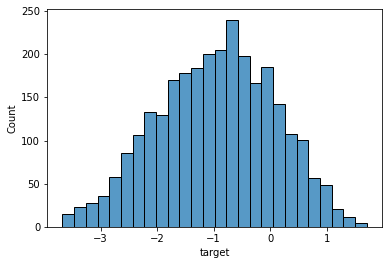

In [5]:
import seaborn as sns
sns.histplot(df_train["target"])

<AxesSubplot:xlabel='standard_error', ylabel='Count'>

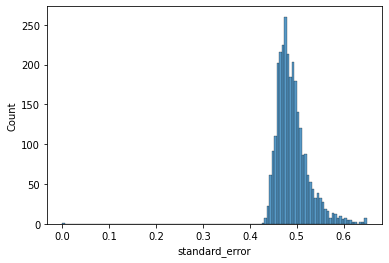

In [6]:
sns.histplot(df_train["standard_error"])

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
class PaddedDataset(Dataset):
    @staticmethod
    def clean_text(text):
        return re.sub('[^A-Za-z0-9.,]+', ' ', str(text).lower())

    def __init__(self, df, tokenizer, max_len, is_test=False):

        self.text = df.excerpt.tolist()
        if not is_test:
            self.target = df.target.tolist()
        self.is_test = is_test
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = self.clean_text(self.text[item])
        
        inputs = self.tokenizer(self.text[item], 
                                max_length=self.max_len, 
                                truncation=True)
        input_ids = inputs["input_ids"]
        padding_length = self.max_len - len(input_ids)
        input_ids = input_ids + ([1] * padding_length)
        attention_mask = inputs["attention_mask"] + ([0] * padding_length)
        
        if self.is_test:
            return {
                "input_ids": torch.tensor(input_ids, dtype=torch.long),
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
            }
    
        return {
                "input_ids": torch.tensor(input_ids, dtype=torch.long),
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "target": torch.tensor(self.target[item], dtype=torch.float)
        }

In [9]:
class CommonLitModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_path)
        self.config = RobertaConfig.from_pretrained(model_path)
        self.W = nn.Linear(1024, 1024)
        self.V = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(0.3) 
        self.fc = nn.Linear(1024, 1)
        
        self._init_weights(self.W)
        self._init_weights(self.V)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, ids, attention):
        output = self.roberta(
            input_ids=ids, 
            attention_mask = attention)
        output = output[0]
        
        attention = torch.tanh(self.W(output))
        score = self.V(attention)
        attention_weights = torch.softmax(score, dim=1)
        output = attention_weights * output
        output = torch.sum(output, dim=1)

        output = self.dropout(output)
        output = self.fc(output)
        
        return output

In [10]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, outputs, targets):
        return torch.sqrt(self.mse(outputs, targets.view(-1, 1)))

In [11]:
def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer, 
               scheduler, 
               criterion, 
               device, 
               accumulation_steps,
               fold):
    
    model.train()
    
    global global_steps
    global min_loss
    
    for i, data in enumerate(tqdm(train_dataloader)):
        input_ids = data["input_ids"]
        attention_mask = data["attention_mask"]
        targets = data["target"]
        
        input_ids = input_ids.to(device, dtype=torch.long)
        attention_mask = attention_mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask)
        optimizer.zero_grad()
        
        loss = criterion(outputs, targets)
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
        optimizer.zero_grad()
        
        global_steps += 1
        if global_steps % 20 == 0:
            loss = eval_fn(model, valid_dataloader, criterion, device)
            if loss < min_loss:
                min_loss = loss
                tokenizer.save_pretrained(f'./data')
                torch.save(model.state_dict(), f'./model{fold}/model.bin')
                
            print(f"{fold}, {global_steps}: {round(loss, 3)}, {round(min_loss, 3)}")

In [12]:
def eval_fn(model, data_loader, criterion, device):
    model.eval()
    
    overall_loss = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"]
            attention_mask = data["attention_mask"]
            targets = data["target"]

            input_ids = input_ids.to(device, dtype=torch.long)
            attention_mask = attention_mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, targets)
    
            overall_loss.append(loss.cpu().detach().numpy().tolist())
        
    return np.mean(overall_loss)

In [13]:
EPOCHS = 3
MAX_LEN = 256
BATCH_SIZE = 8
ACCUMULATION_STEPS = 2
DEVICE = "cuda"
LEARNING_RATE = 2e-5
SEED = 42
N_FOLD = 5
WEIGHT_DECAY = 0.01
# MODEL_PATH = "../input/commonlit-pretrain/commonlit_roberta_large/"
MODEL_PATH = "roberta-large"

In [14]:
set_seed(SEED)

num_bins = int(np.floor(1 + np.log2(len(df_train))))
df_train.loc[:,'bins'] = pd.cut(df_train['target'], 
                                bins=num_bins, 
                                labels=False)
bins = df_train.bins.to_numpy()

kfold = StratifiedKFold(n_splits=N_FOLD, 
                        shuffle=True,
                        random_state=SEED)

for k , (train_idx, valid_idx) in enumerate(kfold.split(X=df_train, y=bins)):
    df_train.loc[valid_idx,'Fold'] = k

In [15]:
losses = []

for fold in range(N_FOLD):
    
    !mkdir ./model$fold
    
    train_df, valid_df = df_train.query(f"Fold!={fold}"), df_train.query(f"Fold=={fold}")
    
    tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

    train_dataset = PaddedDataset(train_df, tokenizer, max_len=MAX_LEN)
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  drop_last=False)

    valid_dataset = PaddedDataset(valid_df, tokenizer, max_len=MAX_LEN)
    valid_dataloader = DataLoader(valid_dataset, 
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  drop_last=False)

    model = CommonLitModel(MODEL_PATH)
    model.to(DEVICE)

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]},
        {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)]},
    ]

    num_train_steps = int(len(train_df) / BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, 
                      lr=LEARNING_RATE,
                      weight_decay=WEIGHT_DECAY)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_dataloader)*5
    )

    criterion = RMSELoss()

    global_steps = 0
    min_loss = float("inf")

    for epoch in range(EPOCHS):
        train_loop(model, 
                   train_dataloader, 
                   valid_dataloader, 
                   optimizer, 
                   scheduler, 
                   criterion, 
                   DEVICE, 
                   ACCUMULATION_STEPS,
                   fold)
        
    losses.append(min_loss)
    print(f"{fold}: {round(min_loss, 3)}")

print(f"RMSE: {round(np.mean(losses), 3)}")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

  7%|▋         | 20/284 [00:39<34:04,  7.74s/it]

0, 20: 1.012, 1.012


 14%|█▍        | 40/284 [01:21<36:27,  8.97s/it]

0, 40: 0.796, 0.796


 21%|██        | 60/284 [01:59<28:32,  7.64s/it]

0, 60: 0.704, 0.704


 28%|██▊       | 80/284 [02:41<30:13,  8.89s/it]

0, 80: 0.668, 0.668


 35%|███▌      | 100/284 [03:14<18:39,  6.08s/it]

0, 100: 0.679, 0.668


 42%|████▏     | 120/284 [03:46<16:37,  6.08s/it]

0, 120: 0.708, 0.668


 49%|████▉     | 140/284 [04:27<20:34,  8.57s/it]

0, 140: 0.613, 0.613


 56%|█████▋    | 160/284 [05:00<12:35,  6.09s/it]

0, 160: 0.765, 0.613


 63%|██████▎   | 180/284 [05:43<15:57,  9.21s/it]

0, 180: 0.588, 0.588


 70%|███████   | 200/284 [06:15<08:31,  6.09s/it]

0, 200: 0.627, 0.588


 77%|███████▋  | 220/284 [06:56<09:06,  8.55s/it]

0, 220: 0.544, 0.544


 85%|████████▍ | 240/284 [07:29<04:27,  6.09s/it]

0, 240: 0.583, 0.544


 92%|█████████▏| 260/284 [08:01<02:25,  6.08s/it]

0, 260: 0.589, 0.544


 99%|█████████▊| 280/284 [08:43<00:36,  9.01s/it]

0, 280: 0.543, 0.543


  6%|▌         | 16/284 [00:29<27:18,  6.12s/it]

0, 300: 0.609, 0.543


 13%|█▎        | 36/284 [01:02<25:10,  6.09s/it]

0, 320: 0.634, 0.543


 20%|█▉        | 56/284 [01:43<33:06,  8.71s/it]

0, 340: 0.538, 0.538


 27%|██▋       | 76/284 [02:15<21:07,  6.09s/it]

0, 360: 0.555, 0.538


 34%|███▍      | 96/284 [02:48<19:03,  6.08s/it]

0, 380: 0.576, 0.538


 41%|████      | 116/284 [03:29<24:24,  8.72s/it]

0, 400: 0.532, 0.532


 48%|████▊     | 136/284 [04:02<14:58,  6.07s/it]

0, 420: 0.536, 0.532


 55%|█████▍    | 156/284 [04:34<12:58,  6.08s/it]

0, 440: 0.534, 0.532


 62%|██████▏   | 176/284 [05:07<10:56,  6.08s/it]

0, 460: 0.564, 0.532


 69%|██████▉   | 196/284 [05:39<08:54,  6.08s/it]

0, 480: 0.537, 0.532


 76%|███████▌  | 216/284 [06:11<06:53,  6.08s/it]

0, 500: 0.692, 0.532


 83%|████████▎ | 236/284 [06:44<04:51,  6.08s/it]

0, 520: 0.563, 0.532


 90%|█████████ | 256/284 [07:26<04:08,  8.86s/it]

0, 540: 0.528, 0.528


 97%|█████████▋| 276/284 [07:58<00:48,  6.09s/it]

0, 560: 0.534, 0.528


  4%|▍         | 12/284 [00:26<27:57,  6.17s/it]

0, 580: 0.665, 0.528


 11%|█▏        | 32/284 [00:59<25:33,  6.08s/it]

0, 600: 0.682, 0.528


 18%|█▊        | 52/284 [01:31<23:30,  6.08s/it]

0, 620: 0.543, 0.528


 25%|██▌       | 72/284 [02:12<30:10,  8.54s/it]

0, 640: 0.521, 0.521


 32%|███▏      | 92/284 [02:44<19:29,  6.09s/it]

0, 660: 0.541, 0.521


 39%|███▉      | 112/284 [03:17<17:27,  6.09s/it]

0, 680: 0.53, 0.521


 46%|████▋     | 132/284 [03:49<15:25,  6.09s/it]

0, 700: 0.527, 0.521


 54%|█████▎    | 152/284 [04:22<13:23,  6.09s/it]

0, 720: 0.568, 0.521


 61%|██████    | 172/284 [04:54<11:21,  6.09s/it]

0, 740: 0.524, 0.521


 68%|██████▊   | 192/284 [05:27<09:19,  6.08s/it]

0, 760: 0.53, 0.521


 75%|███████▍  | 212/284 [06:08<10:30,  8.75s/it]

0, 780: 0.518, 0.518


 82%|████████▏ | 232/284 [06:49<07:34,  8.75s/it]

0, 800: 0.511, 0.511


 89%|████████▊ | 252/284 [07:29<04:18,  8.08s/it]

0, 820: 0.504, 0.504


 96%|█████████▌| 272/284 [08:01<01:13,  6.10s/it]

0, 840: 0.567, 0.504


100%|██████████| 284/284 [08:10<00:00,  1.73s/it]


0: 0.504


  7%|▋         | 20/284 [00:38<34:15,  7.79s/it]

1, 20: 0.927, 0.927


 14%|█▍        | 40/284 [01:15<29:19,  7.21s/it]

1, 40: 0.834, 0.834


 21%|██        | 60/284 [01:51<26:37,  7.13s/it]

1, 60: 0.826, 0.826


 28%|██▊       | 80/284 [02:27<24:31,  7.21s/it]

1, 80: 0.791, 0.791


 35%|███▌      | 100/284 [03:03<21:57,  7.16s/it]

1, 100: 0.709, 0.709


 42%|████▏     | 120/284 [03:39<19:22,  7.09s/it]

1, 120: 0.672, 0.672


 49%|████▉     | 140/284 [04:12<14:35,  6.08s/it]

1, 140: 0.692, 0.672


 56%|█████▋    | 160/284 [04:48<14:48,  7.17s/it]

1, 160: 0.636, 0.636


 63%|██████▎   | 180/284 [05:21<10:34,  6.10s/it]

1, 180: 0.793, 0.636


 70%|███████   | 200/284 [05:57<10:07,  7.24s/it]

1, 200: 0.603, 0.603


 77%|███████▋  | 220/284 [06:30<06:29,  6.08s/it]

1, 220: 0.705, 0.603


 85%|████████▍ | 240/284 [07:02<04:27,  6.08s/it]

1, 240: 0.639, 0.603


 92%|█████████▏| 260/284 [07:35<02:25,  6.08s/it]

1, 260: 0.66, 0.603


 99%|█████████▊| 280/284 [08:07<00:24,  6.08s/it]

1, 280: 0.64, 0.603


  6%|▌         | 16/284 [00:29<27:15,  6.10s/it]

1, 300: 0.653, 0.603


 13%|█▎        | 36/284 [01:05<29:36,  7.16s/it]

1, 320: 0.599, 0.599


 20%|█▉        | 56/284 [01:46<32:22,  8.52s/it]

1, 340: 0.585, 0.585


 27%|██▋       | 76/284 [02:22<24:51,  7.17s/it]

1, 360: 0.561, 0.561


 34%|███▍      | 96/284 [03:03<27:21,  8.73s/it]

1, 380: 0.535, 0.535


 41%|████      | 116/284 [03:36<17:04,  6.10s/it]

1, 400: 0.539, 0.535


 48%|████▊     | 136/284 [04:09<15:01,  6.09s/it]

1, 420: 0.575, 0.535


 55%|█████▍    | 156/284 [04:41<12:58,  6.08s/it]

1, 440: 0.557, 0.535


 62%|██████▏   | 176/284 [05:13<10:57,  6.08s/it]

1, 460: 0.651, 0.535


 69%|██████▉   | 196/284 [05:46<08:55,  6.09s/it]

1, 480: 0.558, 0.535


 76%|███████▌  | 216/284 [06:18<06:54,  6.09s/it]

1, 500: 0.547, 0.535


 83%|████████▎ | 236/284 [06:51<04:52,  6.08s/it]

1, 520: 0.646, 0.535


 90%|█████████ | 256/284 [07:23<02:50,  6.09s/it]

1, 540: 0.623, 0.535


 97%|█████████▋| 276/284 [07:56<00:48,  6.09s/it]

1, 560: 0.566, 0.535


  4%|▍         | 12/284 [00:26<27:59,  6.17s/it]

1, 580: 0.586, 0.535


 11%|█▏        | 32/284 [00:59<25:35,  6.09s/it]

1, 600: 0.544, 0.535


 18%|█▊        | 52/284 [01:35<27:44,  7.18s/it]

1, 620: 0.533, 0.533


 25%|██▌       | 72/284 [02:07<21:31,  6.09s/it]

1, 640: 0.537, 0.533


 32%|███▏      | 92/284 [02:43<22:49,  7.13s/it]

1, 660: 0.525, 0.525


 39%|███▉      | 112/284 [03:16<17:29,  6.10s/it]

1, 680: 0.528, 0.525


 46%|████▋     | 132/284 [03:48<15:24,  6.08s/it]

1, 700: 0.53, 0.525


 54%|█████▎    | 152/284 [04:25<15:55,  7.24s/it]

1, 720: 0.516, 0.516


 61%|██████    | 172/284 [05:01<13:17,  7.12s/it]

1, 740: 0.503, 0.503


 68%|██████▊   | 192/284 [05:33<09:19,  6.08s/it]

1, 760: 0.564, 0.503


 75%|███████▍  | 212/284 [06:06<07:18,  6.09s/it]

1, 780: 0.536, 0.503


 82%|████████▏ | 232/284 [06:38<05:16,  6.09s/it]

1, 800: 0.537, 0.503


 89%|████████▊ | 252/284 [07:11<03:15,  6.09s/it]

1, 820: 0.521, 0.503


 96%|█████████▌| 272/284 [07:43<01:13,  6.09s/it]

1, 840: 0.511, 0.503


100%|██████████| 284/284 [07:52<00:00,  1.66s/it]


1: 0.503


  7%|▋         | 20/284 [00:37<32:22,  7.36s/it]

2, 20: 0.807, 0.807


 14%|█▍        | 40/284 [01:14<29:57,  7.37s/it]

2, 40: 0.681, 0.681


 21%|██        | 60/284 [01:46<22:46,  6.10s/it]

2, 60: 0.72, 0.681


 28%|██▊       | 80/284 [02:22<24:12,  7.12s/it]

2, 80: 0.62, 0.62


 35%|███▌      | 100/284 [02:59<22:01,  7.18s/it]

2, 100: 0.599, 0.599


 42%|████▏     | 120/284 [03:31<16:40,  6.10s/it]

2, 120: 0.719, 0.599


 49%|████▉     | 140/284 [04:08<17:14,  7.18s/it]

2, 140: 0.599, 0.599


 56%|█████▋    | 160/284 [04:40<12:35,  6.10s/it]

2, 160: 0.635, 0.599


 63%|██████▎   | 180/284 [05:13<10:33,  6.09s/it]

2, 180: 0.746, 0.599


 70%|███████   | 200/284 [05:49<10:02,  7.17s/it]

2, 200: 0.579, 0.579


 77%|███████▋  | 220/284 [06:22<06:30,  6.10s/it]

2, 220: 0.614, 0.579


 85%|████████▍ | 240/284 [06:54<04:28,  6.09s/it]

2, 240: 0.639, 0.579


 92%|█████████▏| 260/284 [07:27<02:26,  6.11s/it]

2, 260: 0.827, 0.579


 99%|█████████▊| 280/284 [07:59<00:24,  6.11s/it]

2, 280: 0.588, 0.579


  6%|▌         | 16/284 [00:29<27:20,  6.12s/it]

2, 300: 0.598, 0.579


 13%|█▎        | 36/284 [01:05<29:40,  7.18s/it]

2, 320: 0.559, 0.559


 20%|█▉        | 56/284 [01:38<23:10,  6.10s/it]

2, 340: 0.655, 0.559


 27%|██▋       | 76/284 [02:14<24:42,  7.13s/it]

2, 360: 0.558, 0.558


 34%|███▍      | 96/284 [02:47<19:05,  6.09s/it]

2, 380: 0.589, 0.558


 41%|████      | 116/284 [03:22<19:56,  7.12s/it]

2, 400: 0.558, 0.558


 48%|████▊     | 136/284 [03:55<15:00,  6.08s/it]

2, 420: 0.833, 0.558


 55%|█████▍    | 156/284 [04:31<15:24,  7.22s/it]

2, 440: 0.549, 0.549


 62%|██████▏   | 176/284 [05:04<10:57,  6.09s/it]

2, 460: 0.553, 0.549


 69%|██████▉   | 196/284 [05:40<10:32,  7.19s/it]

2, 480: 0.542, 0.542


 76%|███████▌  | 216/284 [06:13<06:54,  6.09s/it]

2, 500: 0.658, 0.542


 83%|████████▎ | 236/284 [06:45<04:52,  6.08s/it]

2, 520: 0.811, 0.542


 90%|█████████ | 256/284 [07:18<02:50,  6.09s/it]

2, 540: 0.631, 0.542


 97%|█████████▋| 276/284 [07:54<00:57,  7.25s/it]

2, 560: 0.535, 0.535


  4%|▍         | 12/284 [00:26<27:58,  6.17s/it]

2, 580: 0.663, 0.535


 11%|█▏        | 32/284 [00:59<25:36,  6.10s/it]

2, 600: 0.663, 0.535


 18%|█▊        | 52/284 [01:35<27:42,  7.17s/it]

2, 620: 0.523, 0.523


 25%|██▌       | 72/284 [02:07<21:31,  6.09s/it]

2, 640: 0.648, 0.523


 32%|███▏      | 92/284 [02:43<22:52,  7.15s/it]

2, 660: 0.512, 0.512


 39%|███▉      | 112/284 [03:16<17:28,  6.09s/it]

2, 680: 0.658, 0.512


 46%|████▋     | 132/284 [03:49<15:26,  6.09s/it]

2, 700: 0.556, 0.512


 54%|█████▎    | 152/284 [04:25<15:57,  7.25s/it]

2, 720: 0.509, 0.509


 61%|██████    | 172/284 [04:57<11:22,  6.10s/it]

2, 740: 0.557, 0.509


 68%|██████▊   | 192/284 [05:30<09:20,  6.10s/it]

2, 760: 0.57, 0.509


 75%|███████▍  | 212/284 [06:02<07:18,  6.10s/it]

2, 780: 0.513, 0.509


 82%|████████▏ | 232/284 [06:35<05:16,  6.09s/it]

2, 800: 0.54, 0.509


 89%|████████▊ | 252/284 [07:11<03:49,  7.18s/it]

2, 820: 0.506, 0.506


 96%|█████████▌| 272/284 [07:44<01:13,  6.10s/it]

2, 840: 0.528, 0.506


100%|██████████| 284/284 [07:52<00:00,  1.66s/it]


2: 0.506


  7%|▋         | 20/284 [00:37<32:15,  7.33s/it]

3, 20: 1.015, 1.015


 14%|█▍        | 40/284 [01:16<32:26,  7.98s/it]

3, 40: 0.923, 0.923


 21%|██        | 60/284 [01:52<26:42,  7.15s/it]

3, 60: 0.681, 0.681


 28%|██▊       | 80/284 [02:24<20:45,  6.11s/it]

3, 80: 0.733, 0.681


 35%|███▌      | 100/284 [03:01<22:03,  7.19s/it]

3, 100: 0.648, 0.648


 42%|████▏     | 120/284 [03:37<19:37,  7.18s/it]

3, 120: 0.623, 0.623


 49%|████▉     | 140/284 [04:10<14:37,  6.10s/it]

3, 140: 0.636, 0.623


 56%|█████▋    | 160/284 [04:42<12:35,  6.10s/it]

3, 160: 0.669, 0.623


 63%|██████▎   | 180/284 [05:18<12:20,  7.12s/it]

3, 180: 0.584, 0.584


 70%|███████   | 200/284 [05:51<08:31,  6.09s/it]

3, 200: 0.739, 0.584


 77%|███████▋  | 220/284 [06:27<07:39,  7.17s/it]

3, 220: 0.57, 0.57


 85%|████████▍ | 240/284 [07:03<05:15,  7.17s/it]

3, 240: 0.542, 0.542


 92%|█████████▏| 260/284 [07:36<02:26,  6.09s/it]

3, 260: 0.65, 0.542


 99%|█████████▊| 280/284 [08:09<00:24,  6.08s/it]

3, 280: 0.547, 0.542


  6%|▌         | 16/284 [00:29<27:16,  6.11s/it]

3, 300: 0.643, 0.542


 13%|█▎        | 36/284 [01:02<25:07,  6.08s/it]

3, 320: 0.548, 0.542


 20%|█▉        | 56/284 [01:34<23:06,  6.08s/it]

3, 340: 0.662, 0.542


 27%|██▋       | 76/284 [02:07<21:05,  6.08s/it]

3, 360: 0.652, 0.542


 34%|███▍      | 96/284 [02:43<22:47,  7.27s/it]

3, 380: 0.54, 0.54


 41%|████      | 116/284 [03:16<17:04,  6.10s/it]

3, 400: 0.618, 0.54


 48%|████▊     | 136/284 [03:53<18:00,  7.30s/it]

3, 420: 0.54, 0.54


 55%|█████▍    | 156/284 [04:29<15:14,  7.15s/it]

3, 440: 0.539, 0.539


 62%|██████▏   | 176/284 [05:05<12:58,  7.21s/it]

3, 460: 0.511, 0.511


 69%|██████▉   | 196/284 [05:38<08:56,  6.09s/it]

3, 480: 0.544, 0.511


 76%|███████▌  | 216/284 [06:14<08:07,  7.17s/it]

3, 500: 0.504, 0.504


 83%|████████▎ | 236/284 [06:46<04:53,  6.11s/it]

3, 520: 0.524, 0.504


 90%|█████████ | 256/284 [07:19<02:50,  6.10s/it]

3, 540: 0.537, 0.504


 97%|█████████▋| 276/284 [07:51<00:48,  6.11s/it]

3, 560: 0.678, 0.504


  4%|▍         | 12/284 [00:26<28:04,  6.19s/it]

3, 580: 0.609, 0.504


 11%|█▏        | 32/284 [01:02<30:09,  7.18s/it]

3, 600: 0.496, 0.496


 18%|█▊        | 52/284 [01:35<23:37,  6.11s/it]

3, 620: 0.499, 0.496


 25%|██▌       | 72/284 [02:08<21:35,  6.11s/it]

3, 640: 0.513, 0.496


 32%|███▏      | 92/284 [02:44<23:04,  7.21s/it]

3, 660: 0.49, 0.49


 39%|███▉      | 112/284 [03:16<17:31,  6.11s/it]

3, 680: 0.55, 0.49


 46%|████▋     | 132/284 [03:49<15:28,  6.11s/it]

3, 700: 0.502, 0.49


 54%|█████▎    | 152/284 [04:22<13:25,  6.10s/it]

3, 720: 0.563, 0.49


 61%|██████    | 172/284 [04:54<11:24,  6.11s/it]

3, 740: 0.529, 0.49


 68%|██████▊   | 192/284 [05:30<10:59,  7.16s/it]

3, 760: 0.479, 0.479


 75%|███████▍  | 212/284 [06:03<07:20,  6.12s/it]

3, 780: 0.497, 0.479


 82%|████████▏ | 232/284 [06:35<05:17,  6.10s/it]

3, 800: 0.48, 0.479


 89%|████████▊ | 252/284 [07:08<03:15,  6.10s/it]

3, 820: 0.481, 0.479


 96%|█████████▌| 272/284 [07:41<01:13,  6.10s/it]

3, 840: 0.489, 0.479


100%|██████████| 284/284 [07:49<00:00,  1.65s/it]


3: 0.479


  7%|▋         | 20/284 [00:37<32:50,  7.46s/it]

4, 20: 0.914, 0.914


 14%|█▍        | 40/284 [01:17<33:03,  8.13s/it]

4, 40: 0.731, 0.731


 21%|██        | 60/284 [01:53<26:55,  7.21s/it]

4, 60: 0.673, 0.673


 28%|██▊       | 80/284 [02:29<24:26,  7.19s/it]

4, 80: 0.643, 0.643


 35%|███▌      | 100/284 [03:05<21:49,  7.12s/it]

4, 100: 0.628, 0.628


 42%|████▏     | 120/284 [03:38<16:38,  6.09s/it]

4, 120: 0.633, 0.628


 49%|████▉     | 140/284 [04:11<14:35,  6.08s/it]

4, 140: 0.651, 0.628


 56%|█████▋    | 160/284 [04:47<14:43,  7.12s/it]

4, 160: 0.603, 0.603


 63%|██████▎   | 180/284 [05:20<10:32,  6.08s/it]

4, 180: 0.736, 0.603


 70%|███████   | 200/284 [05:57<10:17,  7.35s/it]

4, 200: 0.576, 0.576


 77%|███████▋  | 220/284 [06:33<07:37,  7.14s/it]

4, 220: 0.537, 0.537


 85%|████████▍ | 240/284 [07:09<05:14,  7.15s/it]

4, 240: 0.531, 0.531


 92%|█████████▏| 260/284 [07:42<02:26,  6.09s/it]

4, 260: 0.695, 0.531


 99%|█████████▊| 280/284 [08:15<00:24,  6.10s/it]

4, 280: 0.657, 0.531


  6%|▌         | 16/284 [00:29<27:23,  6.13s/it]

4, 300: 0.867, 0.531


 13%|█▎        | 36/284 [01:02<25:12,  6.10s/it]

4, 320: 0.593, 0.531


 20%|█▉        | 56/284 [01:34<23:11,  6.10s/it]

4, 340: 0.577, 0.531


 27%|██▋       | 76/284 [02:07<21:10,  6.11s/it]

4, 360: 0.573, 0.531


 34%|███▍      | 96/284 [02:39<19:06,  6.10s/it]

4, 380: 0.578, 0.531


 41%|████      | 116/284 [03:12<17:04,  6.10s/it]

4, 400: 0.622, 0.531


 48%|████▊     | 136/284 [03:45<15:01,  6.09s/it]

4, 420: 0.555, 0.531


 55%|█████▍    | 156/284 [04:17<13:00,  6.10s/it]

4, 440: 0.708, 0.531


 62%|██████▏   | 176/284 [04:50<10:57,  6.09s/it]

4, 460: 0.556, 0.531


 69%|██████▉   | 196/284 [05:22<08:56,  6.09s/it]

4, 480: 0.561, 0.531


 76%|███████▌  | 216/284 [05:55<06:54,  6.09s/it]

4, 500: 0.653, 0.531


 83%|████████▎ | 236/284 [06:27<04:52,  6.09s/it]

4, 520: 0.534, 0.531


 90%|█████████ | 256/284 [07:00<02:50,  6.09s/it]

4, 540: 0.587, 0.531


 97%|█████████▋| 276/284 [07:32<00:48,  6.09s/it]

4, 560: 0.543, 0.531


  4%|▍         | 12/284 [00:26<28:00,  6.18s/it]

4, 580: 0.718, 0.531


 11%|█▏        | 32/284 [01:02<30:08,  7.18s/it]

4, 600: 0.526, 0.526


 18%|█▊        | 52/284 [01:35<23:34,  6.10s/it]

4, 620: 0.581, 0.526


 25%|██▌       | 72/284 [02:08<21:31,  6.09s/it]

4, 640: 0.562, 0.526


 32%|███▏      | 92/284 [02:44<22:51,  7.14s/it]

4, 660: 0.52, 0.52


 39%|███▉      | 112/284 [03:20<20:28,  7.14s/it]

4, 680: 0.503, 0.503


 46%|████▋     | 132/284 [03:52<15:25,  6.09s/it]

4, 700: 0.549, 0.503


 54%|█████▎    | 152/284 [04:25<13:24,  6.09s/it]

4, 720: 0.591, 0.503


 61%|██████    | 172/284 [04:57<11:22,  6.10s/it]

4, 740: 0.51, 0.503


 68%|██████▊   | 192/284 [05:30<09:20,  6.09s/it]

4, 760: 0.509, 0.503


 75%|███████▍  | 212/284 [06:02<07:18,  6.09s/it]

4, 780: 0.558, 0.503


 82%|████████▏ | 232/284 [06:35<05:16,  6.09s/it]

4, 800: 0.531, 0.503


 89%|████████▊ | 252/284 [07:08<03:14,  6.09s/it]

4, 820: 0.547, 0.503


 96%|█████████▌| 272/284 [07:40<01:13,  6.09s/it]

4, 840: 0.534, 0.503


100%|██████████| 284/284 [07:49<00:00,  1.65s/it]

4: 0.503
RMSE: 0.499
